In [1]:
import os
import uuid
import asyncio
from typing import TypedDict, List
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, END
from IPython.display import Image, display

load_dotenv(override=True)
OPENAI_API_KEY = os.environ["OPENAI_API_KEY"]

llm = ChatOpenAI(model="gpt-5-nano",temperature=0,api_key=OPENAI_API_KEY,streaming=False)

streaming_llm = ChatOpenAI(model="gpt-5-nano",temperature=0,api_key=OPENAI_API_KEY,streaming=True
)

In [2]:
class AgentState(TypedDict):
    trace_id: str
    user_input: str
    plan: List[str]
    current_step: int
    step_output: str
    verified: bool
    final_answer: str

In [3]:
async def planner_node(state: AgentState):

    prompt = f"""
    Break the following task into 3–5 ordered steps:

    {state["user_input"]}

    Return steps as numbered list.
    """

    response = await llm.ainvoke([HumanMessage(content=prompt)])

    steps = [
        step.strip()
        for step in response.content.split("\n")
        if step.strip()
    ]

    return {
        "plan": steps,
        "current_step": 0
    }

In [4]:
async def executor_node(state: AgentState):

    step = state["plan"][state["current_step"]]

    prompt = f"""
    Execute this step clearly and correctly:

    {step}
    """

    response = await llm.ainvoke([HumanMessage(content=prompt)])

    return {
        "step_output": response.content
    }

In [5]:
async def verifier_node(state: AgentState):

    prompt = f"""
    Verify whether the following output satisfies the step.

    Step:
    {state["plan"][state["current_step"]]}

    Output:
    {state["step_output"]}

    Respond ONLY with:
    yes
    or
    no
    """

    response = await llm.ainvoke([HumanMessage(content=prompt)])

    decision = response.content.strip().lower()

    if decision == "yes":
        next_step = state["current_step"] + 1
        is_done = next_step >= len(state["plan"])

        return {
            "verified": True,
            "current_step": next_step
        }
    else:
        return {
            "verified": False
        }

In [6]:
async def final_response_node(state: AgentState):

    prompt = f"""
    Based on the completed execution steps, provide a clear final answer for:

    {state["user_input"]}

    Final verified output:
    {state["step_output"]}
    """

    print("\n--- Final Response ---\n")

    final_text = ""

    async for chunk in streaming_llm.astream(
        [HumanMessage(content=prompt)]
    ):
        if chunk.content:
            print(chunk.content, end="", flush=True)
            final_text += chunk.content

    return {
        "final_answer": final_text
    }

In [7]:
def route_verification(state: AgentState):
    if not state["verified"]:
        return "executor"
    elif state["current_step"] >= len(state["plan"]):
        return "final_response"
    else:
        return "executor"

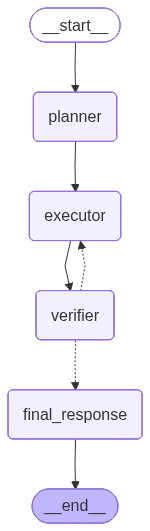

In [8]:
workflow = StateGraph(AgentState)

workflow.add_node("planner", planner_node)
workflow.add_node("executor", executor_node)
workflow.add_node("verifier", verifier_node)
workflow.add_node("final_response", final_response_node)

workflow.set_entry_point("planner")

workflow.add_edge("planner", "executor")
workflow.add_edge("executor", "verifier")

workflow.add_conditional_edges(
    "verifier",
    route_verification,
    {
        "executor": "executor",
        "final_response": "final_response"
    }
)

workflow.add_edge("final_response", END)

graph = workflow.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
async def run():

    initial_state = {
        "trace_id": str(uuid.uuid4()),
        "user_input": "Explain how neural networks work",
        "plan": [],
        "current_step": 0,
        "step_output": "",
        "verified": False,
        "final_answer": ""
    }

    await graph.ainvoke(initial_state)

await run()


--- Final Response ---

Here is a clear, concise explanation of how neural networks work.

- What they are
  - Neural networks are sets of simple processing units (neurons) organized in layers that learn to map inputs to outputs. They adjust their internal parameters (weights and biases) during training so the overall network can perform tasks like classification, regression, or sequence modeling.

- The basic building block
  - Each neuron receives inputs, computes a weighted sum, adds a bias, and then applies a nonlinear activation function.
  - For a neuron, z = w1·x1 + w2·x2 + ... + wn·xn + b, and then a = φ(z), where φ is an activation function (e.g., ReLU, sigmoid, tanh).

- Layers and data flow
  - Input layer: raw data features (e.g., pixel values, word embeddings).
  - Hidden layers: successive transformations that learn increasingly abstract features.
  - Output layer: produces the final prediction (e.g., class probabilities or a numeric value).
  - Forward pass: data moves 